In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading the Content and Style Images

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
CONTENT_ROOT = '/content/drive/MyDrive/HUST GIFTED CLASS K66/IPSAL LAB/Computer vision/Slides/ha-noi-mua-thu.jpg'
STYLE_ROOT = '/content/drive/MyDrive/HUST GIFTED CLASS K66/IPSAL LAB/Computer vision/Slides/b67dea862cafc91a5f151c3e6837d7dd.jpg'

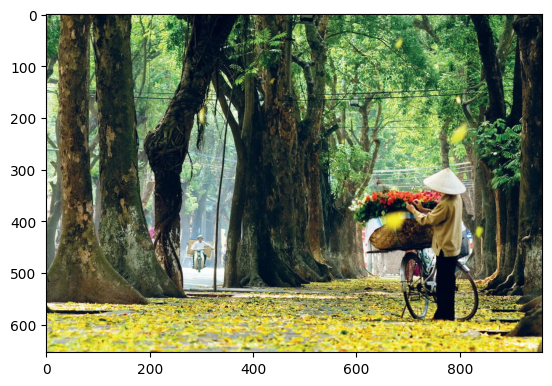

In [ ]:
from PIL import Image
content_img = Image.open(CONTENT_ROOT)
plt.imshow(content_img)

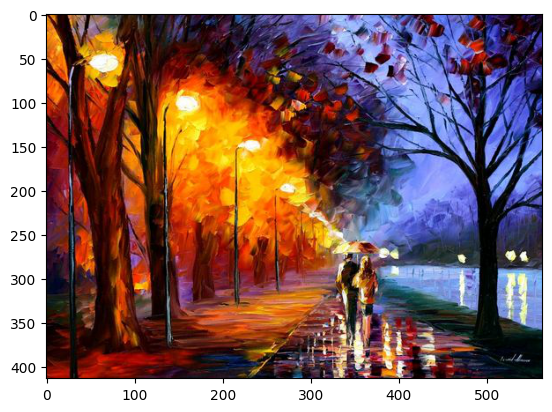

In [ ]:
style_img = Image.open(STYLE_ROOT)
plt.imshow(style_img)

## Preprocessing and Postprocessing

In [ ]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transform = transforms.Compose([
        transforms.Resize(image_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean = rgb_mean, std = rgb_std)
    ])
    return transform(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0)*rgb_std + rgb_mean, 0, 1)
    return transforms.ToPILImage()(img.permute(2, 0, 1))

## Extracting Features

In [ ]:
pretrained_net = torchvision.models.vgg19(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [ ]:
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

In [ ]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [ ]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## Defining the Loss Function

### Content Loss

In [ ]:
def content_loss(Y_hat, Y):
    # We detach the target content from the tree used to dynamically compute
    # the gradient: this is a stated value, not a variable. Otherwise the loss
    # will throw an error.
    return torch.square(Y_hat - Y.detach()).mean()

### Style Loss

In [ ]:
def gram(X):
    num_channels, n = X.shape[1], X.numel()//X.shape[1]
    X = X.reshape(num_channels, n)
    return torch.mm(X, X.T)/(num_channels + n)

In [ ]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

### Total Variation Loss

In [ ]:
def tv_loss(Y_hat):
    return 0.5*(torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() + 
                torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

### Loss Function

In [ ]:
content_weight, style_weight, tv_weight = 1, 1e4, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y)*content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y
    )]
    styles_l = [style_loss(Y_hat, Y)*style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram
    )]
    tv_l = tv_loss(X)*tv_weight
    # Add up all the losses
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## Initializing the Synthesized Image

In [ ]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [ ]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr = lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## Training

In [ ]:
from matplotlib_inline import backend_inline
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

In [ ]:
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [ ]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim), axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [ ]:
import collections
import inspect
from IPython import display

In [ ]:
class Animator:
    """For ploting data in animation."""
    def __init__(self, xlabel = None, ylabel = None, legend = None, xlim = None,
                 ylim = None, xscale = 'linear', yscale = 'linear',
                 fmts = ('-', 'm--', 'g-.', 'r:'), nrows = 1, ncols = 1,
                 figsize = (3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize = figsize)
        if nrows*ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend   
        )
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, '__len__'):
            y = [y]
        n = len(y)
        if not hasattr(x, '__len__'):
            x = [x]*n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait = True)

In [ ]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = Animator(xlabel = 'epoch', ylabel = 'loss',
                        xlim = [10, num_epochs],
                        legend = ['content', 'style', 'TV'],
                        ncols = 2, figsize = (7, 2.5))
    
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram
        )
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1)%10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch+1, [float(sum(contents_l)),
                                   float(sum(styles_l)), float(tv_l)])
    return X


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import numpy as np

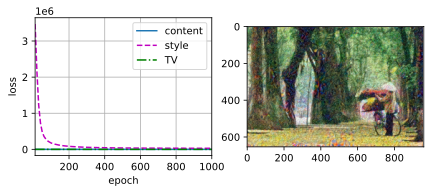

In [ ]:
image_shape = np.array(content_img).shape[:-1]
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 1000, 50)

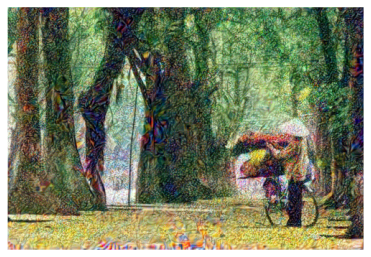

In [ ]:
synthesized_img = postprocess(output)
plt.imshow(synthesized_img)
plt.axis('off')
plt.savefig('/content/drive/MyDrive/HUST GIFTED CLASS K66/Temp/Ha Noi synthesized', bbox_inches = 'tight')